In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import varpro 

SyntaxError: invalid syntax (varpro.py, line 26)

Provided equally spaced points centered about the origin. 

In [11]:
def grid(number_of_points, center): 
    return np.arange(-number_of_points / 2 + center, number_of_points / 2 + 1 + center)

t = grid(128, 0)

## Forward Direction

### Construct latent signal. 

In [15]:
latent_signal = np.piecewise(t, [t<0, t>=0], [0, 1])

## Plotting. 

See [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html#examples-using-matplotlib-gridspec-gridspec) for more details. 

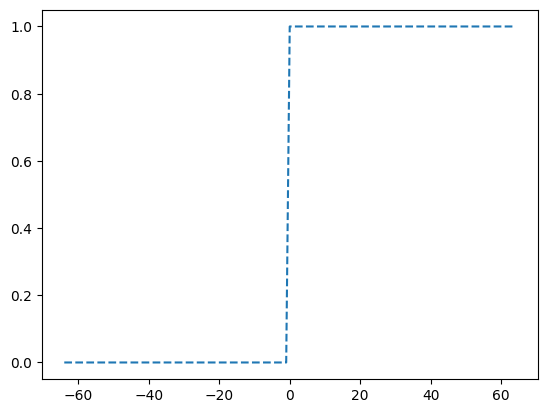

In [25]:
fig, ax = plt.subplots()
ax.plot(t, latent_signal, '--')
